In [1]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random

# configs
random.seed(18)
np.random.seed(18)
pd.set_option("display.max_column", 35)

# Routines

In [2]:
LABEL_ENCODERS = dict()

def dataCleaning(data: pd.DataFrame) -> pd.DataFrame:
  
  # make all columns to lower case
  data.columns = data.columns.str.lower()

  # make all data to be lower case
  data = data.apply(lambda col: col.str.lower() if col.dtype == 'object' else col )

  # drop columns
  # if 'ID' in data.columns: data.drop(columns=['ID'], inplace=True)

  if 'country_id' in data.columns.values:
    data.drop(columns=['country_id'], inplace=True)

  # date columns
  date_cols = ['disbursement_date', 'due_date']
  for col in date_cols:
    data[col] = pd.to_datetime(data[col])
    # extract month, day, and year from the date columns
    data[col+'_month'] = data[col].dt.month
    data[col+'_day'] = data[col].dt.day
    data[col+'_year'] = data[col].dt.year

  # drop the dates columns
  data.drop(columns=date_cols, inplace=True)

  # encode object columns
  for column_name in data[['loan_type', 'new_versus_repeat']]:
    le = LabelEncoder()
    data[f"{column_name}_cat"] = le.fit_transform(data[column_name])
    LABEL_ENCODERS[column_name] = le

  return data

# Data Loading

In [3]:
df = pd.read_csv("./african-credit-scoring-challenge/Train.csv")
df

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
0,ID_266671248032267278,266671,Kenya,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,7,Repeat Loan,120.85,0.014305,121.0,0
1,ID_248919228515267278,248919,Kenya,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,7,Repeat Loan,7768.50,0.300000,7794.0,0
2,ID_308486370501251804,308486,Kenya,370501,251804,Type_7,6900.0,7142.0,2024-09-06,2024-09-13,7,Repeat Loan,1380.00,0.200000,1428.0,0
3,ID_266004285009267278,266004,Kenya,285009,267278,Type_1,8958.0,9233.0,2022-10-20,2022-10-27,7,Repeat Loan,2687.40,0.300000,2770.0,0
4,ID_253803305312267278,253803,Kenya,305312,267278,Type_1,4564.0,4728.0,2022-11-28,2022-12-05,7,Repeat Loan,1369.20,0.300000,1418.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68649,ID_244559228408267278,244559,Kenya,228408,267278,Type_1,1460.0,1515.0,2022-07-30,2022-08-06,7,Repeat Loan,438.00,0.300000,455.0,0
68650,ID_260062217784267278,260062,Kenya,217784,267278,Type_1,5029.0,5116.0,2022-07-16,2022-07-23,7,Repeat Loan,1508.70,0.300000,1535.0,0
68651,ID_259137216701267278,259137,Kenya,216701,267278,Type_1,5289.0,5289.0,2022-07-15,2022-07-22,7,Repeat Loan,1586.70,0.300000,1587.0,0
68652,ID_266801303201267278,266801,Kenya,303201,267278,Type_1,3334.0,3334.0,2022-11-23,2022-11-30,7,Repeat Loan,741.09,0.222283,741.0,0


In [4]:
df.columns

Index(['ID', 'customer_id', 'country_id', 'tbl_loan_id', 'lender_id',
       'loan_type', 'Total_Amount', 'Total_Amount_to_Repay',
       'disbursement_date', 'due_date', 'duration', 'New_versus_Repeat',
       'Amount_Funded_By_Lender', 'Lender_portion_Funded',
       'Lender_portion_to_be_repaid', 'target'],
      dtype='object')

# Data Cleaning

In [5]:
df.head()

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
0,ID_266671248032267278,266671,Kenya,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,7,Repeat Loan,120.85,0.014305,121.0,0
1,ID_248919228515267278,248919,Kenya,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,7,Repeat Loan,7768.50,0.300000,7794.0,0
2,ID_308486370501251804,308486,Kenya,370501,251804,Type_7,6900.0,7142.0,2024-09-06,2024-09-13,7,Repeat Loan,1380.00,0.200000,1428.0,0
3,ID_266004285009267278,266004,Kenya,285009,267278,Type_1,8958.0,9233.0,2022-10-20,2022-10-27,7,Repeat Loan,2687.40,0.300000,2770.0,0
4,ID_253803305312267278,253803,Kenya,305312,267278,Type_1,4564.0,4728.0,2022-11-28,2022-12-05,7,Repeat Loan,1369.20,0.300000,1418.0,0


### Drop Column

In [6]:
# to delete : country_id, ID, 
df.drop(columns=['ID', 'country_id'], inplace=True)
df.head(2)

,customer_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
0,266671,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,7,Repeat Loan,120.85,0.014305,121.0,0
1,248919,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,7,Repeat Loan,7768.50,0.300000,7794.0,0


In [7]:
# make columns and data to lower case
df.columns = df.columns.str.lower()
df = df.apply(lambda col: col.str.lower() if col.dtype == 'object' else col )

In [8]:
date_cols = ['disbursement_date', 'due_date']
for col in date_cols:
  df[col] = pd.to_datetime(df[col])
  # Extract month, day, and year from the date columns
  df[col+'_month'] = df[col].dt.month
  df[col+'_day'] = df[col].dt.day
  df[col+'_year'] = df[col].dt.year

# drop the dates columns
df.drop(columns=date_cols, inplace=True)

df.head()

,customer_id,tbl_loan_id,lender_id,loan_type,total_amount,total_amount_to_repay,duration,new_versus_repeat,amount_funded_by_lender,lender_portion_funded,lender_portion_to_be_repaid,target,disbursement_date_month,disbursement_date_day,disbursement_date_year,due_date_month,due_date_day,due_date_year
0,266671,248032,267278,type_1,8448.0,8448.0,7,repeat loan,120.85,0.014305,121.0,0,8,30,2022,9,6,2022
1,248919,228515,267278,type_1,25895.0,25979.0,7,repeat loan,7768.50,0.300000,7794.0,0,7,30,2022,8,6,2022
2,308486,370501,251804,type_7,6900.0,7142.0,7,repeat loan,1380.00,0.200000,1428.0,0,9,6,2024,9,13,2024
3,266004,285009,267278,type_1,8958.0,9233.0,7,repeat loan,2687.40,0.300000,2770.0,0,10,20,2022,10,27,2022
4,253803,305312,267278,type_1,4564.0,4728.0,7,repeat loan,1369.20,0.300000,1418.0,0,11,28,2022,12,5,2022


In [9]:
df['due_date_year'].value_counts()

due_date_year
2022    64235
2024     3102
2023     1284
2021       27
2025        6
Name: count, dtype: int64

### Columns Encoding

In [10]:
df.dtypes.to_frame().T

,customer_id,tbl_loan_id,lender_id,loan_type,total_amount,total_amount_to_repay,duration,new_versus_repeat,amount_funded_by_lender,lender_portion_funded,lender_portion_to_be_repaid,target,disbursement_date_month,disbursement_date_day,disbursement_date_year,due_date_month,due_date_day,due_date_year
0,int64,int64,int64,object,float64,float64,int64,object,float64,float64,float64,int64,int32,int32,int32,int32,int32,int32


In [11]:
df.isnull().sum().to_frame().T

,customer_id,tbl_loan_id,lender_id,loan_type,total_amount,total_amount_to_repay,duration,new_versus_repeat,amount_funded_by_lender,lender_portion_funded,lender_portion_to_be_repaid,target,disbursement_date_month,disbursement_date_day,disbursement_date_year,due_date_month,due_date_day,due_date_year
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
LABEL_ENCODERS = dict()
# 
for column_name in df[['loan_type', 'new_versus_repeat']]:
  le = LabelEncoder()
  df[f"{column_name}_cat"] = le.fit_transform(df[column_name])
  LABEL_ENCODERS[column_name] = le

In [13]:
df.head()

,customer_id,tbl_loan_id,lender_id,loan_type,total_amount,total_amount_to_repay,duration,new_versus_repeat,amount_funded_by_lender,lender_portion_funded,lender_portion_to_be_repaid,target,disbursement_date_month,disbursement_date_day,disbursement_date_year,due_date_month,due_date_day,due_date_year,loan_type_cat,new_versus_repeat_cat
0,266671,248032,267278,type_1,8448.0,8448.0,7,repeat loan,120.85,0.014305,121.0,0,8,30,2022,9,6,2022,0,1
1,248919,228515,267278,type_1,25895.0,25979.0,7,repeat loan,7768.50,0.300000,7794.0,0,7,30,2022,8,6,2022,0,1
2,308486,370501,251804,type_7,6900.0,7142.0,7,repeat loan,1380.00,0.200000,1428.0,0,9,6,2024,9,13,2024,20,1
3,266004,285009,267278,type_1,8958.0,9233.0,7,repeat loan,2687.40,0.300000,2770.0,0,10,20,2022,10,27,2022,0,1
4,253803,305312,267278,type_1,4564.0,4728.0,7,repeat loan,1369.20,0.300000,1418.0,0,11,28,2022,12,5,2022,0,1


# Data Viz

In [14]:
df.head()

,customer_id,tbl_loan_id,lender_id,loan_type,total_amount,total_amount_to_repay,duration,new_versus_repeat,amount_funded_by_lender,lender_portion_funded,lender_portion_to_be_repaid,target,disbursement_date_month,disbursement_date_day,disbursement_date_year,due_date_month,due_date_day,due_date_year,loan_type_cat,new_versus_repeat_cat
0,266671,248032,267278,type_1,8448.0,8448.0,7,repeat loan,120.85,0.014305,121.0,0,8,30,2022,9,6,2022,0,1
1,248919,228515,267278,type_1,25895.0,25979.0,7,repeat loan,7768.50,0.300000,7794.0,0,7,30,2022,8,6,2022,0,1
2,308486,370501,251804,type_7,6900.0,7142.0,7,repeat loan,1380.00,0.200000,1428.0,0,9,6,2024,9,13,2024,20,1
3,266004,285009,267278,type_1,8958.0,9233.0,7,repeat loan,2687.40,0.300000,2770.0,0,10,20,2022,10,27,2022,0,1
4,253803,305312,267278,type_1,4564.0,4728.0,7,repeat loan,1369.20,0.300000,1418.0,0,11,28,2022,12,5,2022,0,1


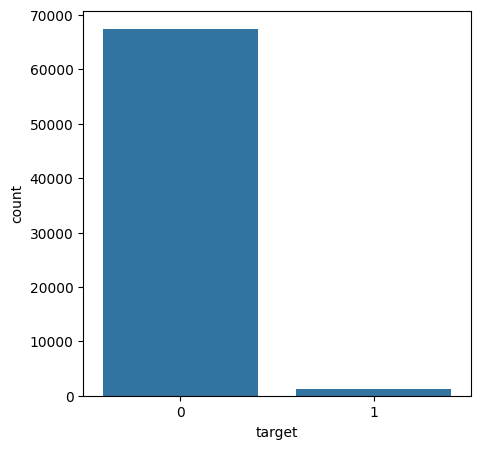

In [15]:
plt.figure(figsize=(5, 5))
sns.countplot(data=df, x='target')
plt.show()

# Data Prep

In [16]:
df.head(2)

,customer_id,tbl_loan_id,lender_id,loan_type,total_amount,total_amount_to_repay,duration,new_versus_repeat,amount_funded_by_lender,lender_portion_funded,lender_portion_to_be_repaid,target,disbursement_date_month,disbursement_date_day,disbursement_date_year,due_date_month,due_date_day,due_date_year,loan_type_cat,new_versus_repeat_cat
0,266671,248032,267278,type_1,8448.0,8448.0,7,repeat loan,120.85,0.014305,121.0,0,8,30,2022,9,6,2022,0,1
1,248919,228515,267278,type_1,25895.0,25979.0,7,repeat loan,7768.50,0.300000,7794.0,0,7,30,2022,8,6,2022,0,1


In [17]:
X = df.drop(columns=['target', 'loan_type', 'new_versus_repeat'])
Y = df['target']
print(X.shape, Y.shape)
X.head(2)

(68654, 17) (68654,)


,customer_id,tbl_loan_id,lender_id,total_amount,total_amount_to_repay,duration,amount_funded_by_lender,lender_portion_funded,lender_portion_to_be_repaid,disbursement_date_month,disbursement_date_day,disbursement_date_year,due_date_month,due_date_day,due_date_year,loan_type_cat,new_versus_repeat_cat
0,266671,248032,267278,8448.0,8448.0,7,120.85,0.014305,121.0,8,30,2022,9,6,2022,0,1
1,248919,228515,267278,25895.0,25979.0,7,7768.50,0.300000,7794.0,7,30,2022,8,6,2022,0,1


In [18]:
features_for_modelling = X.columns
print(list(features_for_modelling.values).__len__())
list(features_for_modelling.values)

17


['customer_id',
 'tbl_loan_id',
 'lender_id',
 'total_amount',
 'total_amount_to_repay',
 'duration',
 'amount_funded_by_lender',
 'lender_portion_funded',
 'lender_portion_to_be_repaid',
 'disbursement_date_month',
 'disbursement_date_day',
 'disbursement_date_year',
 'due_date_month',
 'due_date_day',
 'due_date_year',
 'loan_type_cat',
 'new_versus_repeat_cat']

In [19]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=18)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((54923, 17), (54923,), (13731, 17), (13731,))

In [20]:
print("TARGET TRAIN")
y_train.value_counts()

TARGET TRAIN


target
0    53926
1      997
Name: count, dtype: int64

In [21]:
print("TARGET TEST")
y_test.value_counts()

TARGET TEST


target
0    13470
1      261
Name: count, dtype: int64

# Models

In [22]:
X.shape, Y.shape

((68654, 17), (68654,))

In [23]:
# xgb_clf = XGBClassifier(
#   eval_metric="logloss"
# )

# # Define the parameter grid for the grid search
# param_grid = {
#     'n_estimators': [100, 200, 300, 350, 400, 540, 500],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [5, 7, 9, 11, 15],
#     'subsample': [0.8, 1.0, 1.5, 2, 3],
#     'colsample_bytree': [0.8, 1.0]
# }

# # Set up GridSearchCV with cross-validation
# grid_search = GridSearchCV(
#     estimator=xgb_clf,
#     param_grid=param_grid,
#     scoring='f1',  # choose a metric that - 'f1', 'roc_auc'
#     cv=5, # number of folds in cross-validation
#     # verbose=1, # message
#     n_jobs=-1  # use all cores
# )

# # fit model with grid search
# grid_search.fit(X, Y)

# # get  best parameters and score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print("Best Parameters:", best_params)
# print("Best Cross-Validation Score:", best_score)


In [24]:
# {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 400, 'subsample': 1.0}

xgb = XGBClassifier(
  colsample_bytree=1.0,
  learning_rate=0.2,
  max_depth=5,
  n_estimators=400,
  subsample=1.0
)

xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [25]:
ypred = xgb.predict(x_test)

In [26]:
print(
  classification_report(y_test, ypred, zero_division=1)
)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     13470
           1       0.88      0.70      0.78       261

    accuracy                           0.99     13731
   macro avg       0.94      0.85      0.89     13731
weighted avg       0.99      0.99      0.99     13731



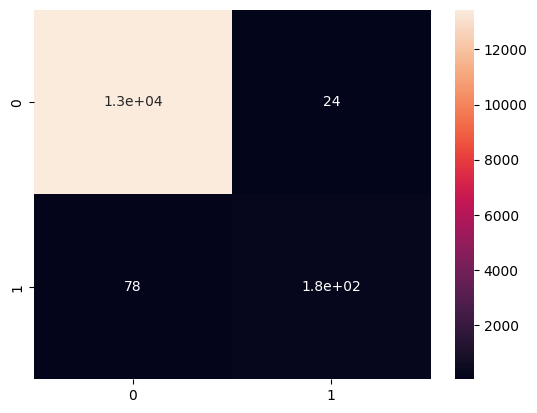

In [27]:
conf = confusion_matrix(y_test, ypred)
sns.heatmap(conf, annot=True)
plt.show()

# Submit

In [28]:
test_df = pd.read_csv("./african-credit-scoring-challenge/Test.csv")
print(test_df.shape)
test_df.head(2)

(18594, 15)


,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid
0,ID_269404226088267278,269404,Kenya,226088,267278,Type_1,1919.0,1989.0,2022-07-27,2022-08-03,7,Repeat Loan,575.7,0.3,597.0
1,ID_255356300042267278,255356,Kenya,300042,267278,Type_1,2138.0,2153.0,2022-11-16,2022-11-23,7,Repeat Loan,0.0,0.0,0.0


In [29]:
test_df = dataCleaning(test_df)
test_df.head(2)

,id,customer_id,tbl_loan_id,lender_id,loan_type,total_amount,total_amount_to_repay,duration,new_versus_repeat,amount_funded_by_lender,lender_portion_funded,lender_portion_to_be_repaid,disbursement_date_month,disbursement_date_day,disbursement_date_year,due_date_month,due_date_day,due_date_year,loan_type_cat,new_versus_repeat_cat
0,id_269404226088267278,269404,226088,267278,type_1,1919.0,1989.0,7,repeat loan,575.7,0.3,597.0,7,27,2022,8,3,2022,0,1
1,id_255356300042267278,255356,300042,267278,type_1,2138.0,2153.0,7,repeat loan,0.0,0.0,0.0,11,16,2022,11,23,2022,0,1


In [30]:
test_df[features_for_modelling].head()

,customer_id,tbl_loan_id,lender_id,total_amount,total_amount_to_repay,duration,amount_funded_by_lender,lender_portion_funded,lender_portion_to_be_repaid,disbursement_date_month,disbursement_date_day,disbursement_date_year,due_date_month,due_date_day,due_date_year,loan_type_cat,new_versus_repeat_cat
0,269404,226088,267278,1919.0,1989.0,7,575.7,0.300000,597.0,7,27,2022,8,3,2022,0,1
1,255356,300042,267278,2138.0,2153.0,7,0.0,0.000000,0.0,11,16,2022,11,23,2022,0,1
2,257026,243764,267278,8254.0,8304.0,7,207.0,0.025079,208.0,8,24,2022,8,31,2022,0,1
3,264617,299409,267278,3379.0,3379.0,7,1013.7,0.300000,1014.0,11,15,2022,11,22,2022,0,1
4,247613,296713,267278,120.0,120.0,7,36.0,0.300000,36.0,11,10,2022,11,17,2022,0,1


In [31]:
# Make predictions on the test dataset
test_predictions = xgb.predict(test_df[features_for_modelling])
test_predictions_proba = xgb.predict_proba(test_df[features_for_modelling])[:, 1]

# Save the predictions to a CSV file
test_df['target'] = test_predictions
sub =  test_df[['id', 'target']]
# 
sub = sub.rename(columns={'id': "ID"})
sub['ID'] = sub['ID'].str.upper()
sub.head()

,ID,target
0,ID_269404226088267278,0
1,ID_255356300042267278,0
2,ID_257026243764267278,0
3,ID_264617299409267278,0
4,ID_247613296713267278,0


In [32]:
sub.to_csv('baseline_submission.csv', index=False)